In [21]:
from pathlib import Path
import geopandas as gpd
root = Path.cwd().parents[1] / 'tmp' / 'compare_deliveries'
vector_ref_path = root / 'delivery_1' / 'report' / 'FR_038_3_Block_PK_AREA1_Naskatech_20220922.gpkg'
vector_test_path = root / 'output' / 'change_map_921000_6541000.shp'

In [4]:
import fiona
import pandas as pd
layers = fiona.listlayers(vector_ref_path) 
refs = []
for layer in layers:
    if layer != 'Default':
        ref_df = gpd.read_file(vector_ref_path, layer=layer, crs='EPSG:2154')
        ref_df['error_type'] = layer
        refs.append( ref_df )

,geometry,error_type
0,"POLYGON ((922563.255 6547590.269, 922564.719 6...",ERRORS_DTM
1,"POLYGON ((922545.502 6547524.710, 922547.386 6...",ERRORS_DTM
2,"POLYGON ((922656.092 6542814.462, 922657.504 6...",ERRORS_DTM
3,"POLYGON ((934665.546 6547791.451, 934666.938 6...",ERRORS_DTM
4,"POLYGON ((938531.621 6540917.229, 938533.495 6...",ERRORS_DTM
...,...,...
261,"POLYGON ((923831.799 6544226.228, 923832.387 6...",ERRORS_DTM
262,"POLYGON ((923874.957 6544247.219, 923875.560 6...",ERRORS_DTM
263,"POLYGON ((923920.193 6544279.004, 923921.086 6...",ERRORS_DTM
264,"POLYGON ((923809.676 6544214.891, 923810.270 6...",ERRORS_DTM


In [8]:
ref = pd.concat(refs)
ref

,geometry,error_type
0,"POLYGON ((922563.255 6547590.269, 922564.719 6...",ERRORS_DTM
1,"POLYGON ((922545.502 6547524.710, 922547.386 6...",ERRORS_DTM
2,"POLYGON ((922656.092 6542814.462, 922657.504 6...",ERRORS_DTM
3,"POLYGON ((934665.546 6547791.451, 934666.938 6...",ERRORS_DTM
4,"POLYGON ((938531.621 6540917.229, 938533.495 6...",ERRORS_DTM
...,...,...
6,"POLYGON ((928070.279 6540027.262, 928080.551 6...",Errors_cls_65
7,"POLYGON ((928602.180 6540656.153, 928614.276 6...",Errors_cls_65
8,"POLYGON ((927504.488 6547466.904, 927510.925 6...",Errors_cls_65
9,"POLYGON ((924921.110 6542217.421, 924924.832 6...",Errors_cls_65


In [12]:
len(ref[ ref['error_type'] == 'Errors_cls_65' ])

11

In [14]:
ref['error_type'].unique().tolist()

['ERRORS_DTM', 'Errors_raster', 'ERRORS_WATER', 'Errors_cls_65']

In [23]:
test = gpd.read_file(vector_test_path).geometry

In [135]:
print(ref)

0     POLYGON ((922563.255 6547590.269, 922564.719 6...
1     POLYGON ((922545.502 6547524.710, 922547.386 6...
2     POLYGON ((922656.092 6542814.462, 922657.504 6...
3     POLYGON ((934665.546 6547791.451, 934666.938 6...
4     POLYGON ((938531.621 6540917.229, 938533.495 6...
                            ...                        
6     POLYGON ((928070.279 6540027.262, 928080.551 6...
7     POLYGON ((928602.180 6540656.153, 928614.276 6...
8     POLYGON ((927504.488 6547466.904, 927510.925 6...
9     POLYGON ((924921.110 6542217.421, 924924.832 6...
10    POLYGON ((921615.369 6541068.766, 921615.767 6...
Name: geometry, Length: 441, dtype: geometry


Computing statistics between ref and test

In [136]:
stats = {
    'index': [],
    'nb_changes': [],
    'nb_expected_changes': [],
    'coverage_expected_changes_%': [],
    'nb_missing_changes': []
}



In [15]:
tile_name = '921000_6541000'
xmin, ymax = [int(v) for v in tile_name.split('_')]
xmax = xmin + 1000
ymin = ymax - 1000
local_ref = ref.cx[xmin:xmax, ymin:ymax]

In [138]:
inter = local_ref.intersection(test)
inter = inter[inter != None]
inter = inter[~inter.is_empty]
inter

C:\Users\EAL\Anaconda3\envs\lastricks_v2\lib\site-packages\geopandas\base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


GeoSeries([], dtype: geometry)

**Quick overview**

<AxesSubplot: >

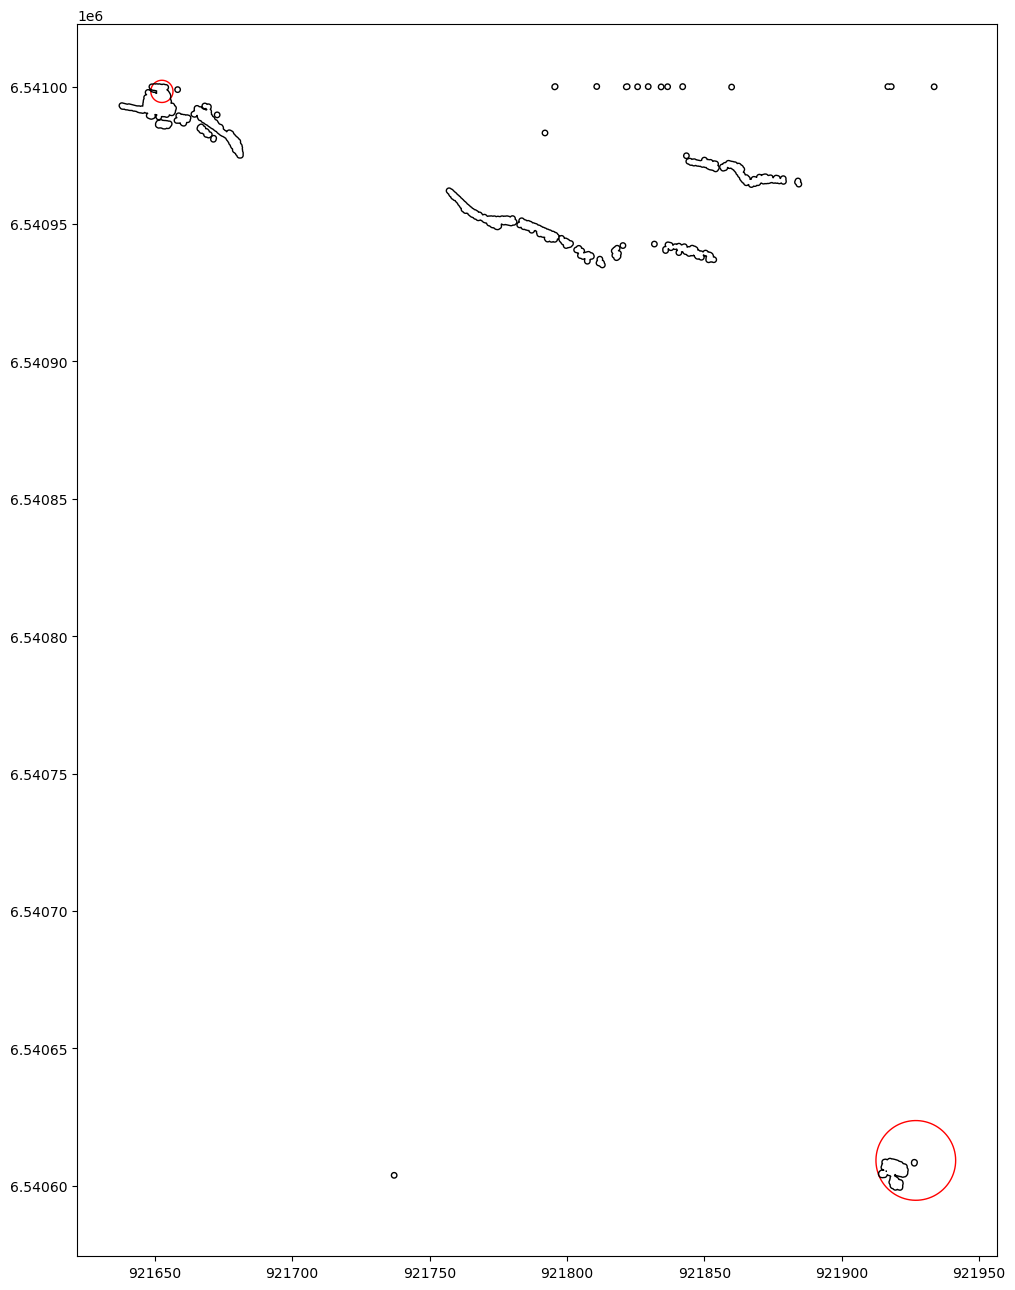

In [139]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (20,16)) 
local_ref.plot(color="none", edgecolor='r', ax=ax)
bounds = local_ref.total_bounds # order: minx, miny, maxx, maxy
test.cx[bounds[0]:bounds[2], bounds[1]:bounds[3]].plot(color="none", edgecolor='k', ax=ax)

Visually, there is clearly an intersection. But thie intersects() and intersection() methods do not yield anything...

Actually, the intersection() and intersects() methods only perform a row-wise comparison. i.e. each geometry of serie 1 will be compared to 1 geometry in serie 2 (and not all of them!).

we have to iterate on one serie of geometries to perform all the intersections we want:

In [123]:
def crop(gs_to_crop: gpd.GeoSeries, ref_gs: gpd.GeoSeries):
    bounds = ref_gs.total_bounds
    return gs_to_crop.cx[bounds[0]:bounds[2], bounds[1]:bounds[3]]

In [141]:
local_ref = local_ref.reset_index(drop=True)
local_ref

0    POLYGON ((921917.565 6540598.169, 921918.352 6...
1    POLYGON ((921652.094 6540994.226, 921652.372 6...
Name: geometry, dtype: geometry

In [149]:
result_mask = []
for ref_geom in local_ref:
    result_mask.append(
     any( test.apply(ref_geom.intersects) )
    )

In [31]:
result_masks = []
for ref_geom in local_ref.geometry:
    result_masks.append(
        test.apply(ref_geom.intersects)
    )
import numpy as np
np.unique(sum(result_masks).astype(bool), return_counts=True)

(array([False,  True]), array([250,   3], dtype=int64))

In [151]:
nb_inter = sum(result_mask)
nb_inter

2

In [152]:
stats['index'].append( tile_name )
stats['nb_changes'].append( len(test) )
stats['nb_expected_changes'].append( len(local_ref) )
stats['coverage_expected_changes_%'].append( nb_inter / len(local_ref) * 100 if len(local_ref) > 0 else 100 )
stats['nb_missing_changes'].append( len(local_ref) - nb_inter )

In [153]:
stats_df = pd.DataFrame( data=stats )

In [154]:
stats_df

,index,nb_changes,nb_expected_changes,coverage_expected_changes_%,nb_missing_changes
0,921000_6541000,253,2,100.0,0
